In [ ]:
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/aa34462255cd487d04be8387a2d572588f6ceee23f784f37365aa714afeb8fe6)


Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=self.max_length, padding="max_length", return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
train_dataset = TweetDataset('train',emotion_dataset,tokenizer)
valid_dataset = TweetDataset('validation',emotion_dataset,tokenizer)
test_dataset = TweetDataset('test',emotion_dataset,tokenizer)

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=64
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,batch_size=64
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
import torch.optim as optim

optimizer = optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = train_dataset[3]['input_ids'] # Получи токены из датасета
mask = train_dataset[3]['mask'] # Получи маску из датасета


In [ ]:
outputs = model_0(input_ids=tokens.to(device),attention_mask=mask.to(device)) # Посмотри на аутпут

In [ ]:
print(outputs.logits)

tensor([[-0.1390,  0.2717,  0.7974, -0.8331,  0.3472,  0.2871]],
       device='cuda:0', grad_fn=<IndexBackward>)


Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device).squeeze(1)
        attention_mask = batch['mask'].to(device).squeeze(1)
        output = model_0(input_ids=input_ids,attention_mask=attention_mask)['logits'].cpu()
        labels = batch['target']
       # print(output.dtype, labels.dtype)
       # print(output)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device).squeeze(1)
            attention_mask = batch['mask'].to(device).squeeze(1)
            output = model_0(input_ids=input_ids,attention_mask=attention_mask)['logits'].cpu()
            labels = batch['target']
            loss = criterion(output, labels)
            valid_loss += loss.item()
            valid_acc += sum(labels == torch.softmax(output,1).argmax(1))/batch_size
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device).squeeze(1)
      attention_mask = batch['mask'].to(device).squeeze(1)
      output = model_0(input_ids=input_ids,attention_mask=attention_mask)['logits'].cpu()
      labels = batch['target']
      test_acc += sum(labels == torch.softmax(output,1).argmax(1))/batch_size

print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.5624775705337524,Valid Loss: 1.4464439190924168,Valid Acc: 0.43310546875



Train Loss: 1.3140665192604064,Valid Loss: 1.0686183162033558,Valid Acc: 0.57958984375



Train Loss: 0.9425490365028382,Valid Loss: 0.7968709580600262,Valid Acc: 0.69091796875



Train Loss: 0.6773423421382904,Valid Loss: 0.6942258533090353,Valid Acc: 0.736328125



Train Loss: 0.5026775709390641,Valid Loss: 0.5970363030210137,Valid Acc: 0.77880859375



Train Loss: 0.3819438180327415,Valid Loss: 0.6141573349013925,Valid Acc: 0.77734375



Train Loss: 0.2955108668804169,Valid Loss: 0.5862433416768909,Valid Acc: 0.79345703125



Train Loss: 0.22961221885681152,Valid Loss: 0.5207050419412553,Valid Acc: 0.81591796875



Train Loss: 0.19112756499648095,Valid Loss: 0.5077133672311902,Valid Acc: 0.828125



Train Loss: 0.1577914498448372,Valid Loss: 0.5142848179675639,Valid Acc: 0.833984375
Test Acc: 0.8232421875


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text =  emotion_dataset['test']['text'][22] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

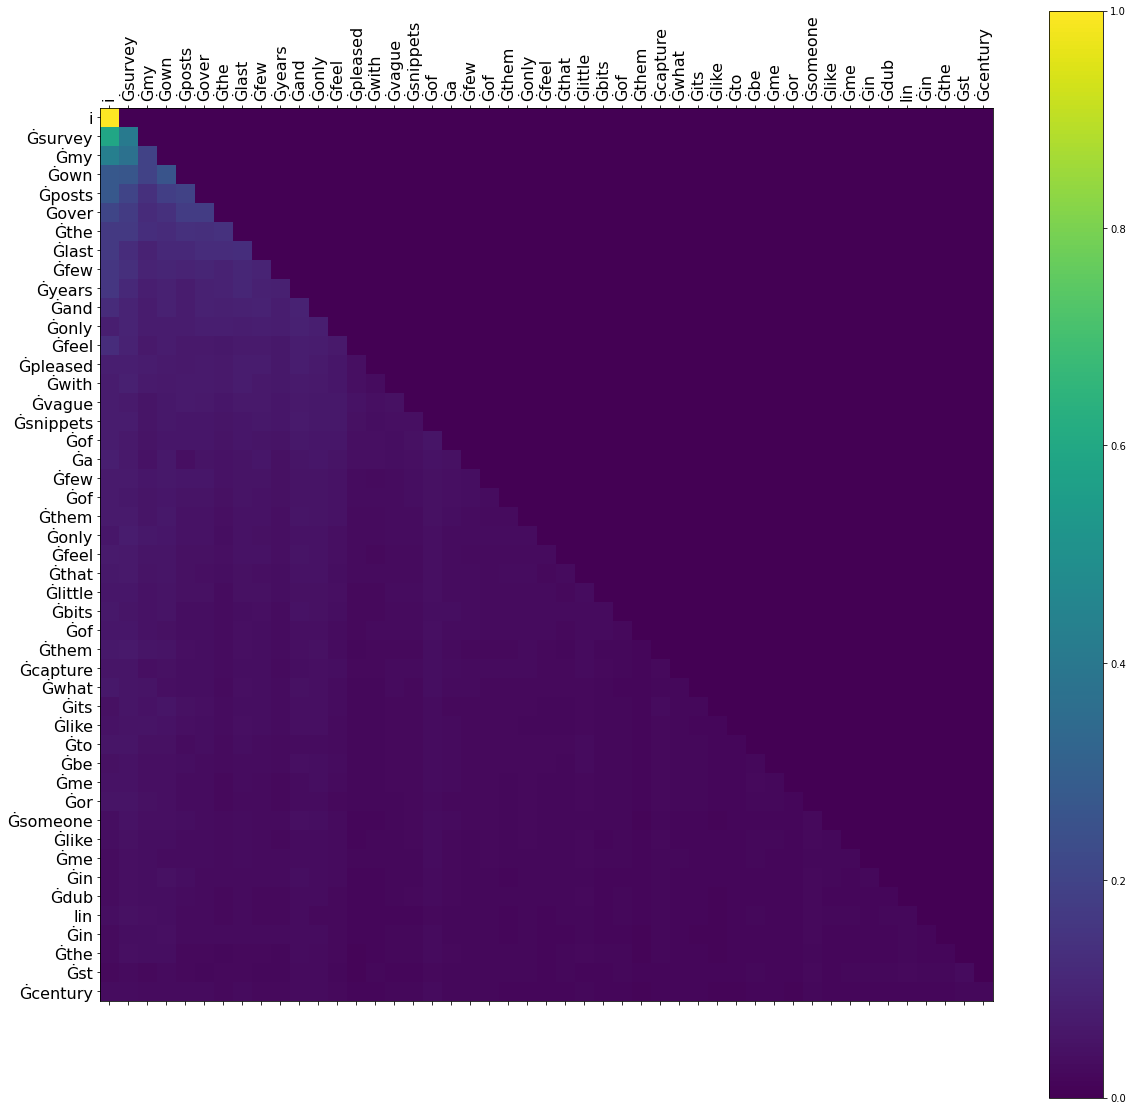

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device).squeeze(1)
        attention_mask = batch['mask'].to(device).squeeze(1)
        output = model_1(input_ids=input_ids,attention_mask=attention_mask)['logits'].cpu()
        labels = batch['target']
       # print(output.dtype, labels.dtype)
       # print(output)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device).squeeze(1)
            attention_mask = batch['mask'].to(device).squeeze(1)
            output = model_1(input_ids=input_ids,attention_mask=attention_mask)['logits'].cpu()
            labels = batch['target']
            loss = criterion(output, labels)
            valid_loss += loss.item()
            valid_acc += sum(labels == torch.softmax(output,1).argmax(1))/batch_size
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device).squeeze(1)
      attention_mask = batch['mask'].to(device).squeeze(1)
      output = model_1(input_ids=input_ids,attention_mask=attention_mask)['logits'].cpu()
      labels = batch['target']
      test_acc += sum(labels == torch.softmax(output,1).argmax(1))/batch_size

print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.6251484756469727,Valid Loss: 1.105792012065649,Valid Acc: 0.5947265625



Train Loss: 0.7824625188112259,Valid Loss: 0.41271993331611156,Valid Acc: 0.83935546875



Train Loss: 0.38480588036775587,Valid Loss: 0.2413099855184555,Valid Acc: 0.89306640625



Train Loss: 0.2653976313173771,Valid Loss: 0.20116415969096124,Valid Acc: 0.9013671875



Train Loss: 0.20964785796403884,Valid Loss: 0.18162714038044214,Valid Acc: 0.90283203125



Train Loss: 0.17282822301983833,Valid Loss: 0.171331329154782,Valid Acc: 0.90478515625



Train Loss: 0.15873953700065613,Valid Loss: 0.15679886809084564,Valid Acc: 0.90283203125



Train Loss: 0.13844860104471446,Valid Loss: 0.15506110526621342,Valid Acc: 0.90966796875



Train Loss: 0.12991663028299807,Valid Loss: 0.15067444613669068,Valid Acc: 0.9072265625



Train Loss: 0.12149464612454176,Valid Loss: 0.14739303587703034,Valid Acc: 0.9091796875
Test Acc: 0.8994140625


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset['test']['text'][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

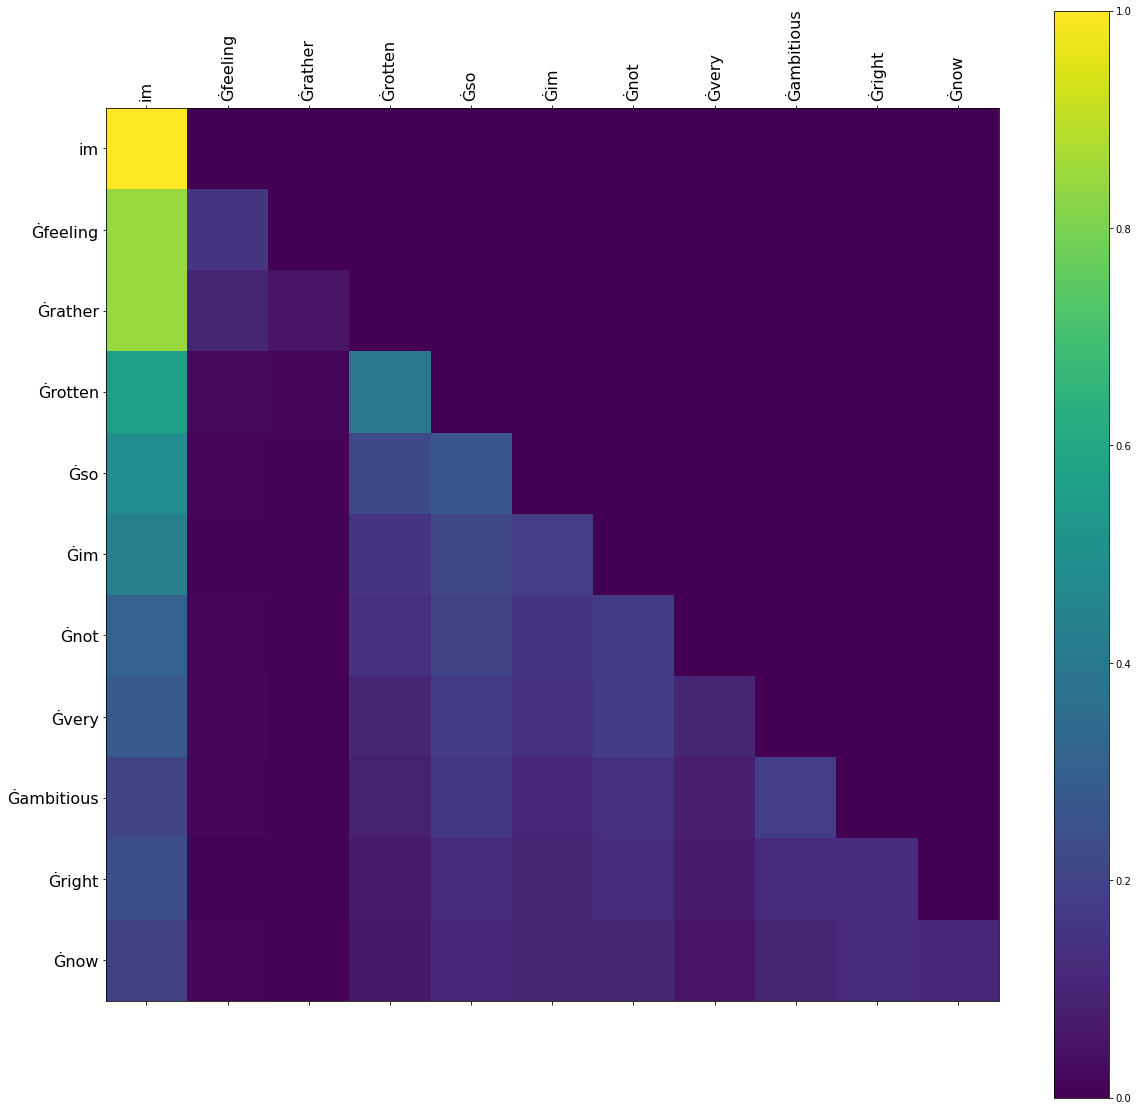

In [ ]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >


> Модель, которая обучалась решать задачу Language Modeling дает нам качество лучше, но прироста в скорости обучения мы не получим, оно сопоставимо с моделью, которую мы обучали с нуля.


> Больше всего обращала внимание на первые слова в предложении.


> В некоторых головах, как мы могли заметить, модель выделяла либо первое слово, либо несколько с интервалами, тем самым выделяя главные, если предложение длинное.
